# **Navigating Healthcare Costs: A Comprehensive Analysis of Medical Costs in the United States**
#### Group 13: Angelina Hsu, Brendan Yuen, Kelly Snow, Jitao Zhang


## Introduction

## Methods and Results

#### Preparations 

In [2]:
# Loading all needed libraries:
library(tidyverse)
library(tidymodels)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(leaps)
library(glmnet)
library(car)
library(faraway)
library(mltools)
library(GGally)
library(ggplot2)
library(gridExtra)

# General Graphs' setting:
options(repr.plot.width = 13, repr.plot.height = 9)   

# Import online dataset
url <- "https://raw.githubusercontent.com/Jitao-Z/Medical-Cost-Personal-Datasets/main/insurance.csv"
raw_data <- read_csv(url)

# First 6 rows of the dataset
head(raw_data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

age sex    bmi    children smoker region    charges  
1 19  female 27.900 0        yes    southwest 16884.924
2 18  male   33.770 1        no     southeast  1725.552
3 28  male   33.000 3        no     southeast  4449.462
4 33  male   22.705 0        no     northwest 21984.471
5 32  male   28.880 0        no     northwest  3866.855
6 31  female 25.740 0        no     southeast  3756.622

### Exploratory Data Analysis (EDA)

#### Data cleaning

In [3]:
medical_cost <- raw_data |>
    filter(!is.na(charges)) |>                        # Check and remove missing values from the raw dataset
    mutate(region = ifelse(region == "southwest" | region == "northwest", "west", "east"),
           children = ifelse(children <= 2, "<=2", ">2"))
medical_cost$sex <- factor(medical_cost$sex)           # Change the property of sex into factor
medical_cost$region <- factor(medical_cost$region)     # Change the property of region into factor
medical_cost$children <- factor(medical_cost$children) # Change the property of children into factor
medical_cost$smoker <- factor(medical_cost$smoker)     # Change the property of smoker into factor

head(medical_cost)

age sex    bmi    children smoker region charges  
1 19  female 27.900 <=2      yes    west   16884.924
2 18  male   33.770 <=2      no     east    1725.552
3 28  male   33.000 >2       no     east    4449.462
4 33  male   22.705 <=2      no     west   21984.471
5 32  male   28.880 <=2      no     west    3866.855
6 31  female 25.740 <=2      no     east    3756.622

#### Plotting Relevant Raw Data 

To get a general idea of potential relationships between all the variables, we started by visualizing the relationship between all variables in the dataset, which was done using ggpairs().

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


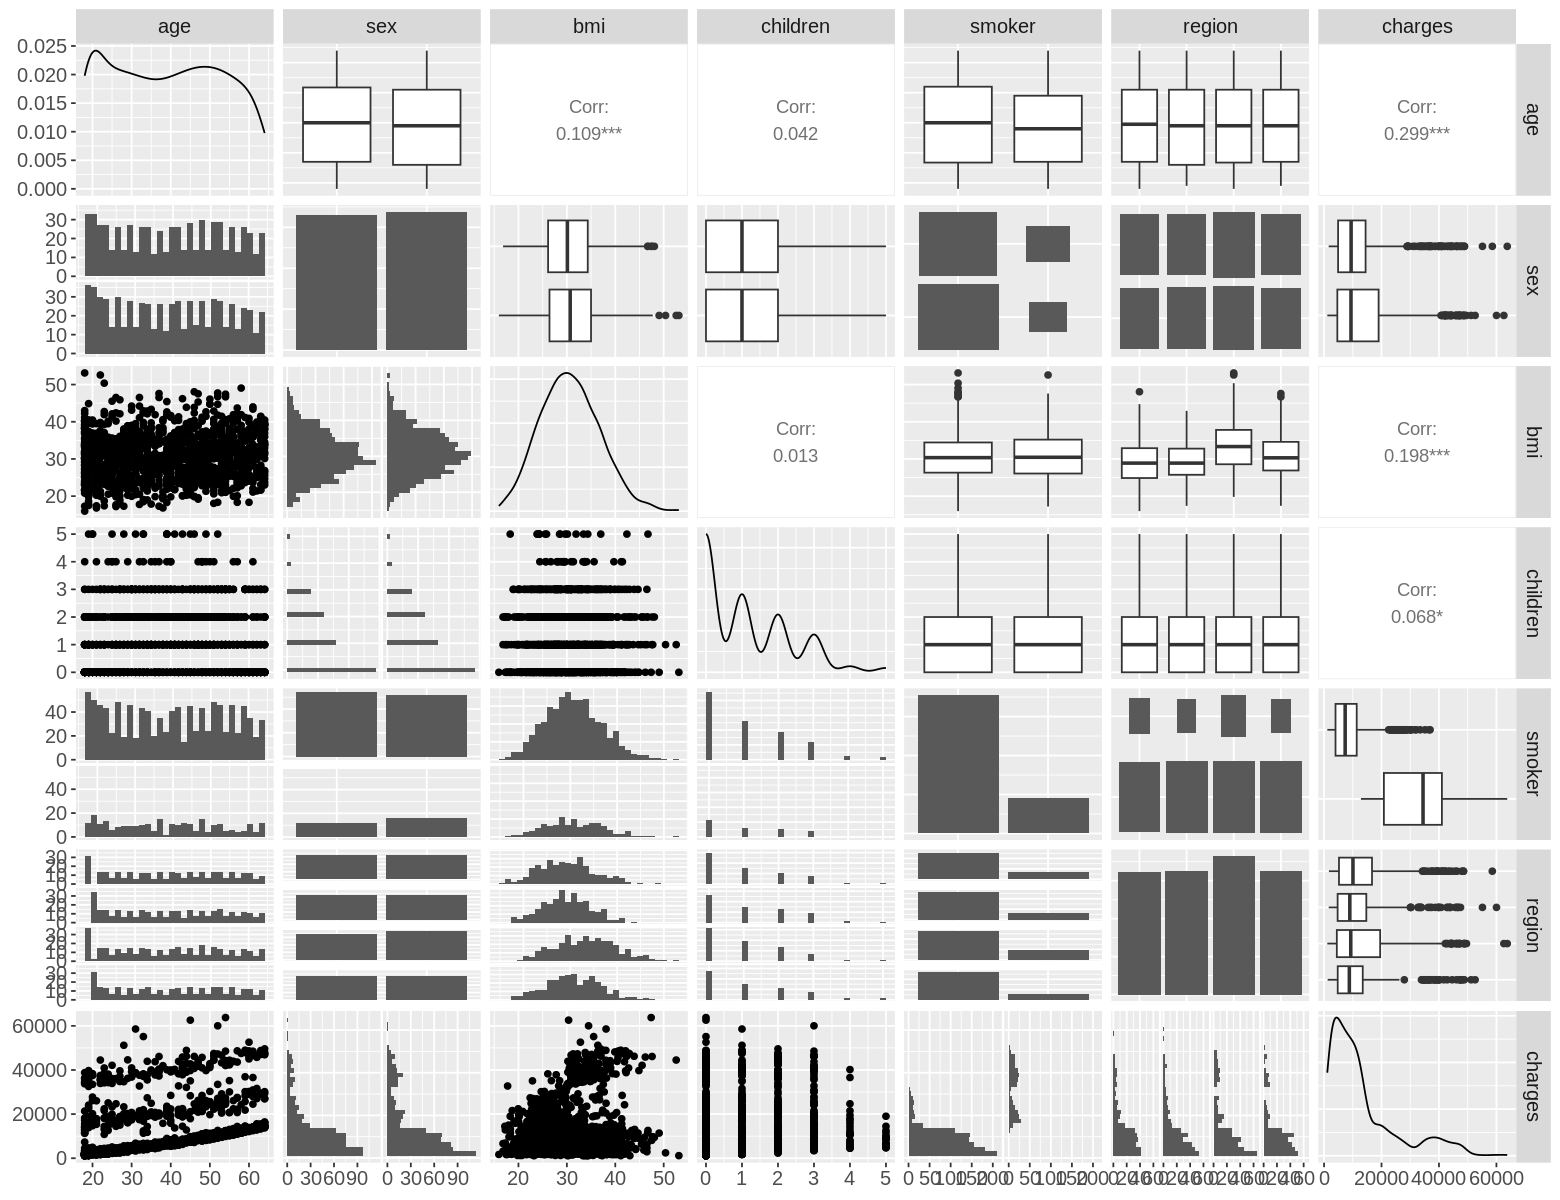

In [4]:
options(repr.plot.width = 13, repr.plot.height = 10)   

medical_raw_plots <- raw_data %>% 
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )

medical_raw_plots

From the output, we noticed a potential relationship between ** ADD MORE INFO HERE

### Methods: Plans

We used Lasso, Ridge and Least-Squares to obtain three different models to preduct charges and compared their predictive performances. Lasso and Ridge shrink estimated coefficients of variables towards zero using a penalty term. Increasing lambda below means that the magnitudes of the estimated coefficients decrease as the penalty term will take up more space in the pre-determined "budget". For our project, we used the default value of lambda which minizes the Mean-Squared Error (MSE) in the `cv.glmnet` function.


The following is a summary of the method used:
- Split the dataset into a training set (70%) and a testing set (30%)
- Convert the training and testing sets into matrix form
- Use the cv.glmnet function with alpha = 0 (for Ridge) to find the value of l which minimizes Mean-Squared Error (MSE) using cross-validation with the training set
- Extract the estimated coefficients of the regularized model with l which minimizes MSE
- Use the regularized model to predict charges in the testing set and compute the Root Mean-Squared Error (RMSE)
- Repeat steps 3-5 but change alpha = 1 (for Lasso)
- Fit a full linear regression model with Least-Squares to the training set
- Use the full linear regression model to predict charges in the testing set and compute the RMSE.
- Compare the RMSE for each model


#### Ridge, Full regression, Lasso

In [38]:
# Set seed to obtain reproducible results
set.seed(1234)

# Split the data into 3 sets - 1 training set, 1 selection set (for selecting a model), 1 testing set (to make predictions with the selected model)
medical_split <- initial_split(medical_cost, prop = 0.5, strata = charges)
medical_training <- training(medical_split)
medical_remaining <- testing(medical_split)

medical_split_remaining <- initial_split(medical_remaining, prop = 0.5, strata = charges)
medical_select <- training(medical_split_remaining)
medical_testing <- testing(medical_split_remaining)


# Change all sets into matrix form required by "glmnet( )"
medical_matrix_X_train <- model.matrix(charges ~ ., medical_training)[, -1]

medical_matrix_Y_train <- as.matrix(medical_training$charges, ncol = 1)

medical_matrix_X_select <- model.matrix(charges ~ ., medical_select)[, -1]

medical_matrix_Y_select <- as.matrix(medical_select$charges, ncol = 1)

medical_matrix_X_test <- model.matrix(charges ~ ., medical_testing)[, -1]

medical_matrix_Y_test <- as.matrix(medical_testing$charges, ncol = 1)

- Ridge

In [39]:
# Provide different levels of lambda on the model to obtain their respective MSE
medical_cv_lambda_ridge <- cv.glmnet(
    x = medical_matrix_X_train, y = medical_matrix_Y_train,
    alpha = 0)               # alpha = 0: Ridge penalty
                             # Here, we do not explicitly set up a range of values for lambda; therefore, the function will use its default argument of lambda for us
medical_cv_lambda_ridge


Call:  cv.glmnet(x = medical_matrix_X_train, y = medical_matrix_Y_train,      alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index  Measure      SE Nonzero
min    915   100 39238706 2336500       6
1se   2320    90 41466296 2598432       6

In [40]:
# Obtain the lambda that provides the smallest MSE
medical_lambda_min_MSE_ridge <- medical_cv_lambda_ridge$lambda.min
medical_lambda_min_MSE_ridge

[1] 915.0401

In [41]:
# Obtain the estimated coefficients of our regularized model by selecting the lambda which provides the smallest MSE
medical_ridge_min_coef <- coef(medical_cv_lambda_ridge, s = "lambda.min")    
medical_ridge_min_coef

7 x 1 sparse Matrix of class "dgCMatrix"
                    s1
(Intercept) -8818.7108
age           246.3660
sexmale      -286.2098
bmi           262.5419
children>2    519.2378
smokeryes   21620.1545
regionwest   -286.2766

In [42]:
# Apply our regularized model on our selection set to predict the corresponding response variable, charges and evaluate the model.
medical_select_pred_ridge_min <- predict(medical_cv_lambda_ridge, newx = medical_matrix_X_select, s = "lambda.min")
head(medical_select_pred_ridge_min)

lambda.min
1 6074.724  
2 2821.808  
3 2475.190  
4 3163.427  
5 3032.156  
6 5120.299

In [43]:
# Calculate the RMSE for the Ridge regression model in the selection set and present it in a table
medical_RMSE_select <- tibble(
    Model = "Ridge Regression with minimum MSE",
    RMSE_selection_set = rmse(preds = medical_select_pred_ridge_min, actuals = medical_matrix_Y_select))
medical_RMSE_select

Model                             RMSE_selection_set
1 Ridge Regression with minimum MSE 6175.794

- Lasso

In [44]:
# Provide different levels of lambda on the model to obtain their respective MSE
medical_cv_lambda_LASSO <- cv.glmnet(
    x = medical_matrix_X_train, y = medical_matrix_Y_train,
    alpha = 1)               # alpha = 1: Lasso penalty
                             # Here, we do not explicitly set up a range of values for lambda; therefore, the function will use its defalut argument of lambda for us
medical_cv_lambda_LASSO


Call:  cv.glmnet(x = medical_matrix_X_train, y = medical_matrix_Y_train,      alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index  Measure      SE Nonzero
min   72.5    53 38493176 2751775       6
1se  981.2    25 41118155 3376012       3

In [45]:
# Obtain the lambda that provides the smallest MSE
medical_lambda_min_MSE_LASSO <- medical_cv_lambda_LASSO$lambda.min
medical_lambda_min_MSE_LASSO

[1] 72.51536

In [46]:
# Obtain the estimated coefficients of our regularized model by selecting the lambda which provides the smallest MSE
medical_LASSO_min_coef <- coef(medical_cv_lambda_LASSO, s = "lambda.min")    
medical_LASSO_min_coef

7 x 1 sparse Matrix of class "dgCMatrix"
                     s1
(Intercept) -10023.7696
age            259.9346
sexmale       -304.1013
bmi            272.9315
children>2     333.1921
smokeryes    23137.3635
regionwest    -115.0766

In [47]:
# Apply our regularized model on the selection set to predict the corresponding response variable, charges, and evaluate the model
medical_select_pred_LASSO_min <- predict(medical_cv_lambda_LASSO, newx = medical_matrix_X_select, s = "lambda.min")
head(medical_select_pred_LASSO_min)

lambda.min
1 5757.220  
2 2158.676  
3 1992.326  
4 2687.630  
5 2551.165  
6 4742.111

In [48]:
# Calculate the RMSE for the Lasso model in the selection set and present it in a table 
medical_RMSE_select <- medical_RMSE_select |> add_row(
    Model = "Lasso Regression with minimum MSE",
    RMSE_selection_set = rmse(preds = medical_select_pred_LASSO_min, actuals = medical_matrix_Y_select))
medical_RMSE_select

Model                             RMSE_selection_set
1 Ridge Regression with minimum MSE 6175.794          
2 Lasso Regression with minimum MSE 6109.997

- Full regression

In [49]:
# We can also fit a full linear regression model on our training set
medical_full_OLS <- lm(charges ~ ., data = medical_training)

In [50]:
# At this point, we can compare the estimated coefficients of all of our three obtained models
medical_reg_coef <- round(cbind(
    Full_OLS = coef(medical_full_OLS),
    Ridge_min = as.vector(medical_ridge_min_coef), 
    Lasso_min = as.vector(medical_LASSO_min_coef)), 1) |> as.data.frame()
medical_reg_coef

Full_OLS Ridge_min Lasso_min
(Intercept) -10483.1 -8818.7   -10023.8 
age            264.8   246.4      259.9 
sexmale       -489.4  -286.2     -304.1 
bmi            284.2   262.5      272.9 
children>2     561.6   519.2      333.2 
smokeryes    23348.1 21620.2    23137.4 
regionwest    -255.5  -286.3     -115.1

In [51]:
# Apply our full linear regression model the selection to predict the corresponding response variable, charges, and evaluate the model
medical_select_full_OLS <- predict(medical_full_OLS, medical_select)

In [52]:
# Calculate the RMSE of the full linear regression model in the selection set and add it to our previous table
medical_RMSE_select <- medical_RMSE_select |>
    add_row(Model = "OLS Full Regression",
            RMSE_selection_set = rmse(preds = medical_select_full_OLS, actuals = medical_select$charges))
medical_RMSE_select

Model                             RMSE_selection_set
1 Ridge Regression with minimum MSE 6175.794          
2 Lasso Regression with minimum MSE 6109.997          
3 OLS Full Regression               6107.096

We select the full linear regression model as it has the lowest RMSE and use it to predict charges in the test set.

In [53]:
medical_test_full_OLS <- predict(medical_full_OLS, medical_testing)
medical_RMSE_select_test <- tibble(Selected_Model = "OLS Full Regression",
                            RMSE_test_set = rmse(preds = medical_test_full_OLS, actuals = medical_testing$charges))
medical_RMSE_select_test

Selected_Model      RMSE_test_set
1 OLS Full Regression 5967.803

## Discussion